# Medical Charges EDA
Quick exploratory data analysis for the `insurance.csv` dataset.

In [114]:
import os


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

import mlflow
import mlflow.sklearn

import joblib

sns.set_style("whitegrid")
%config InlineBackend.figure_format='retina'

In [115]:
df = pd.read_csv("../data/medical_insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,54.907277,female,24.043568,1.995771,no,southwest,9222.721214
1,36.945607,male,23.992936,-0.051169,yes,southwest,28348.593090
2,58.382876,male,22.053382,-0.031955,no,northwest,10438.340609
3,39.207340,female,26.307519,-0.026810,no,northeast,8596.622439
4,18.163581,male,24.950164,0.992198,yes,southwest,24771.844570


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       10000 non-null  float64
 1   sex       10000 non-null  object 
 2   bmi       10000 non-null  float64
 3   children  10000 non-null  float64
 4   smoker    10000 non-null  object 
 5   region    10000 non-null  object 
 6   charges   10000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 547.0+ KB


In [98]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10000.0,39.303467,14.089988,16.922432,26.540854,39.343290,51.453761,64.797094
bmi,10000.0,30.695443,6.084195,15.925826,26.278314,30.513667,34.774844,53.241782
children,10000.0,1.094992,1.207376,-0.088507,0.005896,0.986397,1.997385,5.052517
charges,10000.0,13199.194255,10425.438676,0.729283,5926.163388,9980.008900,15174.928874,44563.265576


## Missing values

In [99]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Target distribution

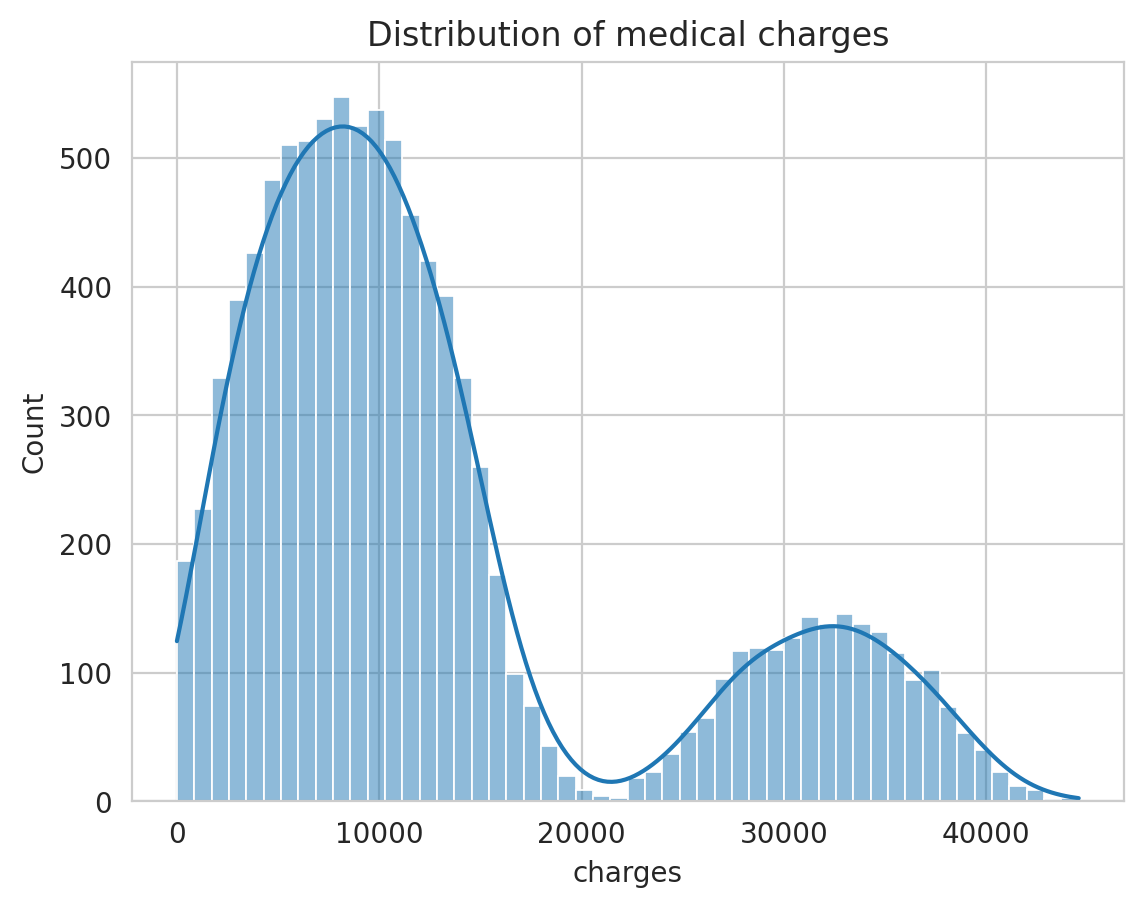

In [100]:
sns.histplot(df["charges"], kde=True)
plt.title("Distribution of medical charges")
plt.show()

## Numeric correlations

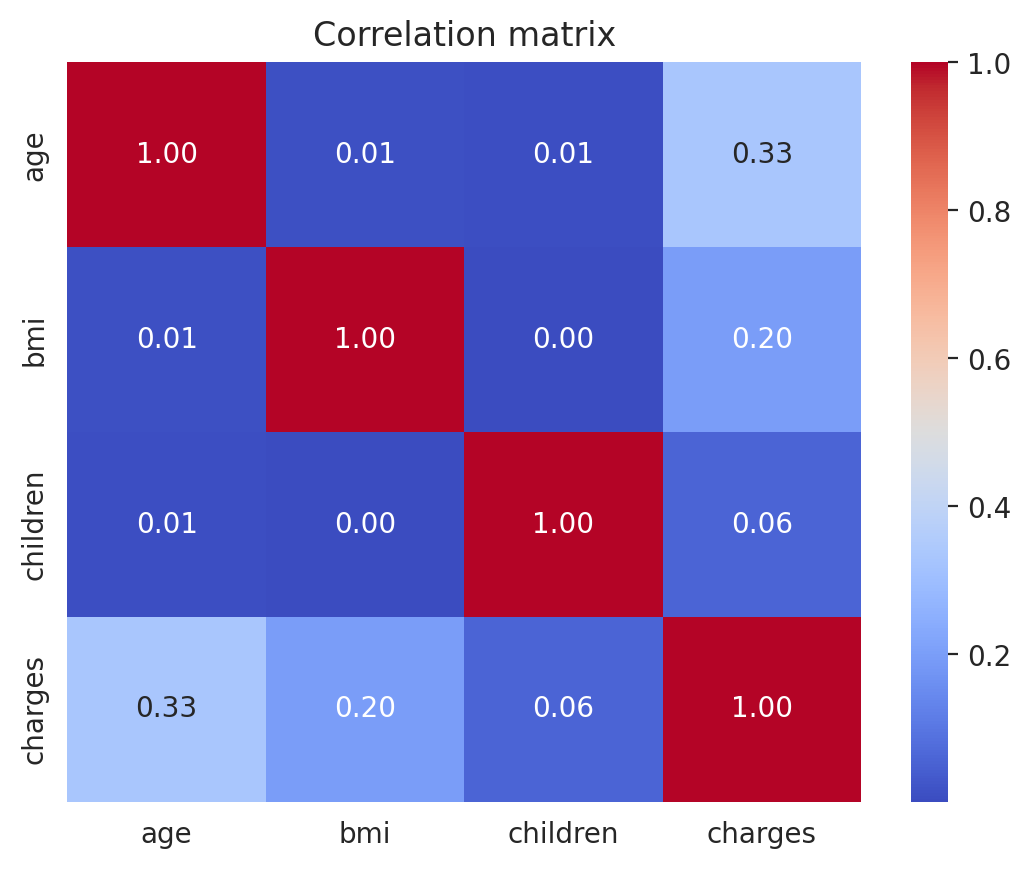

In [101]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

## Age vs charges (with smoker overlay)

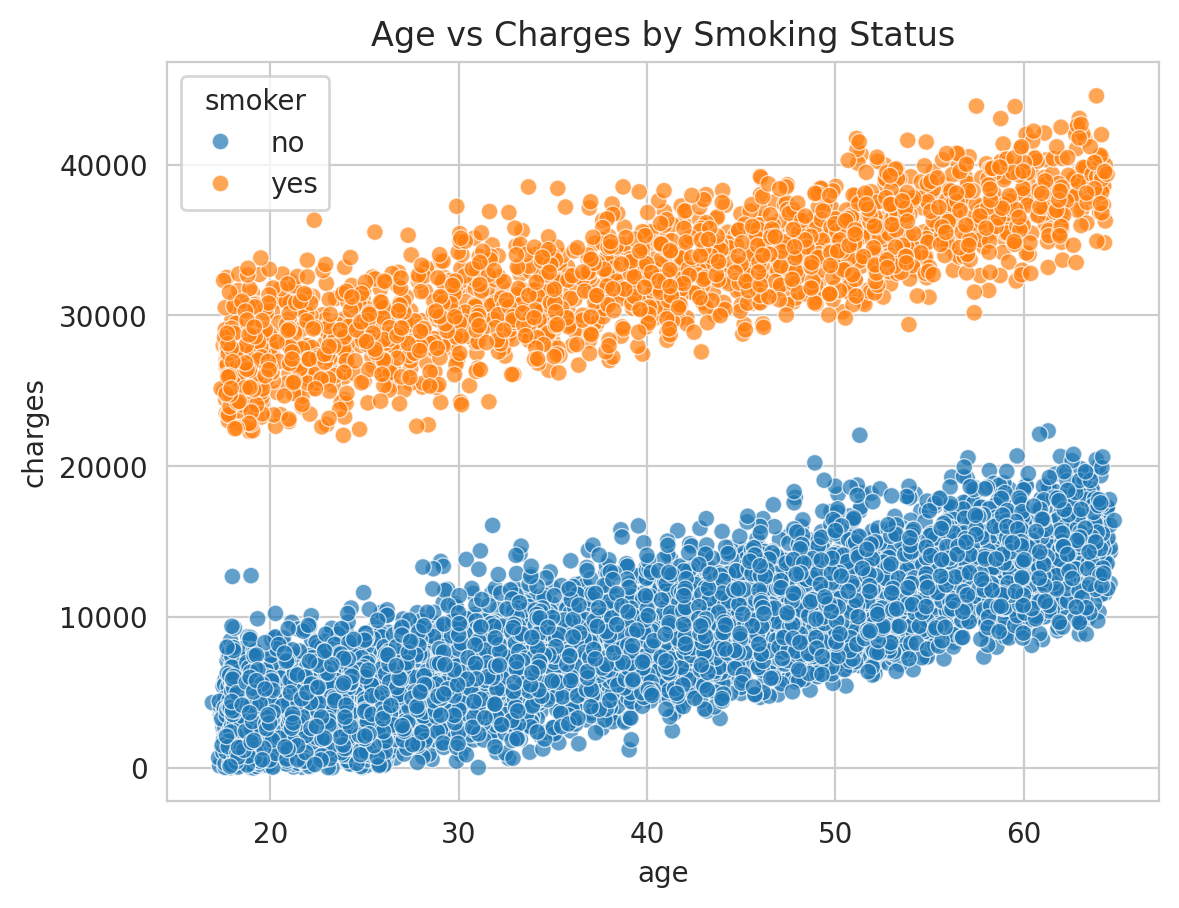

In [102]:
sns.scatterplot(data=df, x="age", y="charges", hue="smoker", alpha=0.7)
plt.title("Age vs Charges by Smoking Status")
plt.show()

## BMI vs charges (with smoker overlay)

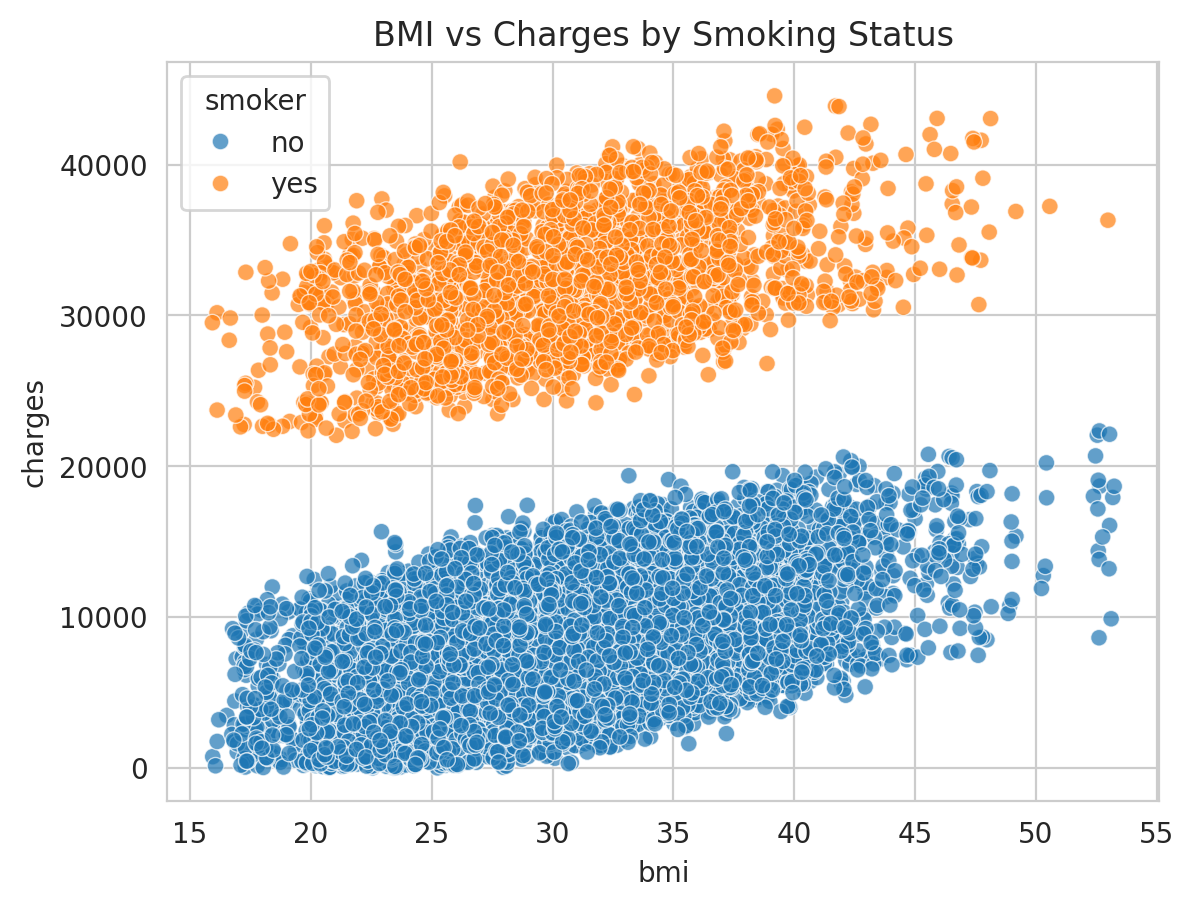

In [103]:
sns.scatterplot(data=df, x="bmi", y="charges", hue="smoker", alpha=0.7)
plt.title("BMI vs Charges by Smoking Status")
plt.show()

In [104]:
# create train and test set 
X = df.drop(columns=['charges'])
y = df['charges']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(8000, 2000, 8000, 2000)

In [117]:
# separate numeric and categorical columns 
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.to_list()
categorical_cols = X.select_dtypes(include=["object"]).columns.to_list()

In [149]:
# standard scaling numerical features 
sc = StandardScaler()
X_train_numeric = pd.DataFrame(
    sc.fit_transform(X_train[numeric_cols]),
    columns=numeric_cols,
    index=X_train.index
)
X_test_numeric = pd.DataFrame(
    sc.fit_transform(X_test[numeric_cols]),
    columns=numeric_cols,
    index=X_test.index
)
len(X_train_numeric), len(X_test_numeric)


(8000, 2000)

In [153]:
# one hot encoding of categorical features 
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_categorical = pd.DataFrame(
    ohe.fit_transform(X_train[categorical_cols]),
    columns=ohe.get_feature_names_out(categorical_cols),
    index=X_train.index
)
X_test_categorical = pd.DataFrame(
    ohe.fit_transform(X_test[categorical_cols]),
    columns=ohe.get_feature_names_out(categorical_cols),
    index=X_test.index
)

len(X_train_categorical), len(X_test_categorical)

(8000, 2000)

In [158]:
# concat both numerical and categorical train set
X_train_preprocessed = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_test_preprocessed = pd.concat([X_test_numeric, X_test_categorical], axis=1)
len(X_train_preprocessed), len(X_test_preprocessed)

(8000, 2000)

In [162]:
# create dicts of models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

In [181]:
# Hyper-parameter grids for some models
param_grids = {
    "Ridge": {"alpha": [0.1, 1, 10]},
    "Lasso": {"alpha": [0.01, 0.1, 1]},
    "ElasticNet": {"alpha": [0.01, 0.1, 1],
                    "l1_ratio": [0.2, 0.5, 0.8]},
    "RandomForest": {"n_estimators": [100, 200],
                        "max_depth": [None, 5, 10]},
    "XGBoost": {"n_estimators": [100, 200],
                "max_depth": [3, 5],
                "learning_rate": [0.05, 0.1]}
}

In [ ]:
best_rmse = np.inf
best_model = None
best_model_name = None

In [187]:
for name, model in models.items():
    print(f"Training model : {name}")

    if name in param_grids:
        grid = GridSearchCV(
            model,
            param_grids[name],
            cv=5,
            scoring="neg_root_mean_squared_error",
            n_jobs=1
        )
        grid.fit(X_train_preprocessed, y_train)
        model = grid.best_estimator_
        print("Best Params: ", grid.best_params_)
    else:
        model.fit(X_train_preprocessed, y_train)
    preds = model.predict(X_test_preprocessed)
    
    rmse = root_mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} Results:")
    print(f" RMSE: {rmse:.2f}")
    print(f" MAE: {mae:.2f}")
    print(f" R2: {r2:.2f}\n")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_model_name = name
print(f"Best model: {best_model} with RMSE: {best_rmse:.2f}")

Training model : LinearRegression
LinearRegression Results:
 RMSE: 994.98
 MAE: 802.64
 R2: 0.99

Training model : Ridge
Best Params:  {'alpha': 0.1}
Ridge Results:
 RMSE: 994.98
 MAE: 802.64
 R2: 0.99

Training model : Lasso
Best Params:  {'alpha': 0.01}
Lasso Results:
 RMSE: 994.98
 MAE: 802.64
 R2: 0.99

Training model : ElasticNet
Best Params:  {'alpha': 0.01, 'l1_ratio': 0.8}
ElasticNet Results:
 RMSE: 997.31
 MAE: 804.06
 R2: 0.99

Training model : RandomForest
Best Params:  {'max_depth': None, 'n_estimators': 200}
RandomForest Results:
 RMSE: 1104.75
 MAE: 886.12
 R2: 0.99

Training model : XGBoost
Best Params:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
XGBoost Results:
 RMSE: 1006.99
 MAE: 809.87
 R2: 0.99

Best model: LinearRegression() with RMSE: 994.98


In [189]:
# save the model 
MODEL_DIR = "../artifacts/best_model"
joblib.dump(best_model, f"{MODEL_DIR}/{best_model_name}.joblib")

['../artifacts/best_model/LinearRegression.joblib']

In [191]:
# load the model 
load_model = joblib.load('../artifacts/best_model/LinearRegression.joblib')

In [213]:
# make prediction on test set
y_pred = load_model.predict(X_test_preprocessed)
rmse = root_mean_squared_error(y_test, y_pred)

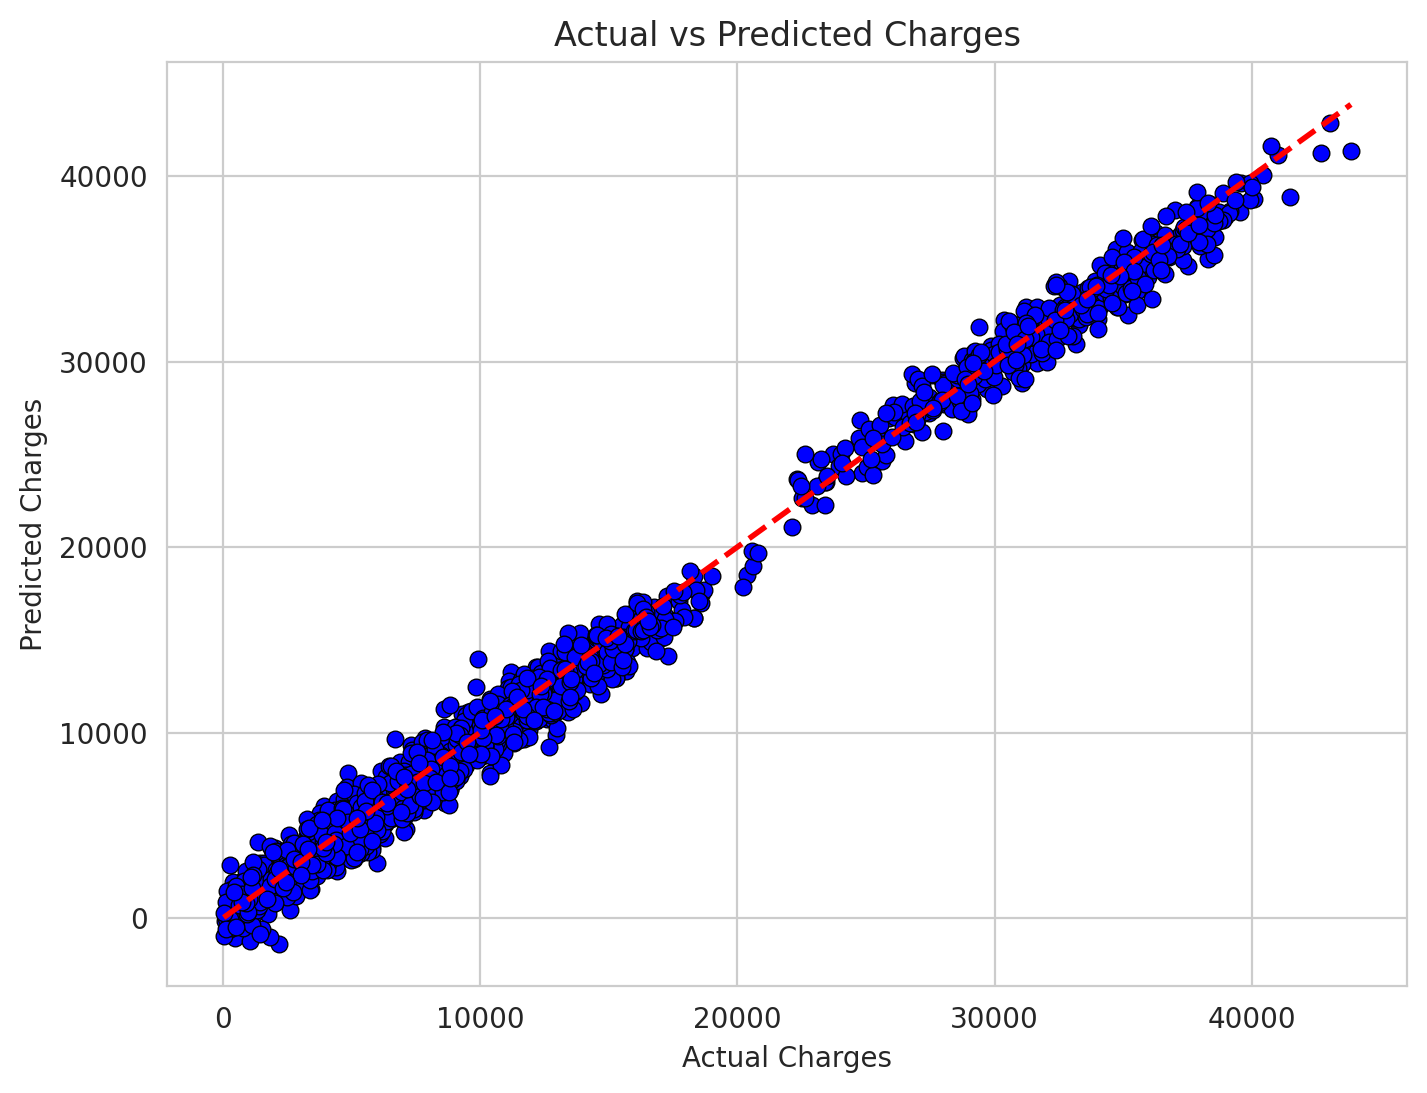

In [217]:
# acutal vs predicted plot 

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.grid(True)
plt.show()

## Summary
- No missing values  
- Charges are right-skewed (log-transform may help)  
- Smokers incur drastically higher charges  
- Age and BMI show moderate positive correlation with charges  
- Region and sex have weaker effects